In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
if (!requireNamespace("umap", quietly = TRUE)) {
  install.packages("umap-learn")
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘umap-learn’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [3]:
install.packages("umap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘RcppEigen’, ‘reticulate’, ‘RSpectra’




In [4]:
BiocManager::install("DESeq2")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'openssl'



In [5]:
install.packages("R.utils")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’




In [6]:
BiocManager::install("GEOquery")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'GEOquery'

also installing the dependencies ‘statmod’, ‘XML’, ‘limma’, ‘rentrez’


Old packages: 'openssl'



In [27]:
# Try installing 'sf' or 'terra' as alternatives to 'maptools'
if (!requireNamespace("sf", quietly = TRUE)) {
  install.packages("sf")
}

# if (!requireNamespace("terra", quietly = TRUE)) {
#   install.packages("terra")
# }

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [40]:
#   Differential expression analysis with limma
library(DESeq2)
library(GEOquery)
library(limma)
library(umap)
library("sf") # or library("terra")
# library("maptools") # point labels without overlaps

terra 1.8.15


Attaching package: ‘terra’


The following objects are masked from ‘package:SummarizedExperiment’:

    distance, nearest, shift, trim, values, values<-, width


The following objects are masked from ‘package:GenomicRanges’:

    distance, gaps, nearest, shift, trim, values, values<-, width


The following objects are masked from ‘package:IRanges’:

    distance, gaps, nearest, shift, trim, width


The following objects are masked from ‘package:S4Vectors’:

    values, values<-, width


The following object is masked from ‘package:BiocGenerics’:

    width




In [8]:
# load series and platform data from GEO
gset <- getGEO("GSE29105", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL6947", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

Found 1 file(s)

GSE29105_series_matrix.txt.gz



In [9]:
# make proper column names to match toptable
fvarLabels(gset) <- make.names(fvarLabels(gset))

In [10]:
# group membership for all samples
gsms <- "000222111"
sml <- strsplit(gsms, split="")[[1]]

In [11]:
# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

In [12]:
# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("AA","BB","BA"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

gset <- gset[complete.cases(exprs(gset)), ] # skip missing values

fit <- lmFit(gset, design)  # fit linear model

In [13]:
# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups, c(tail(groups, -1), head(groups, 1)), sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

In [31]:
# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

# tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","F","GI","SEQUENCE","GB_ACC","Gene.symbol","Gene.title"))
# write.table(tT, file=stdout(), row.names=F, sep="\t")

In [15]:
print(colnames(tT))

 [1] "ID"                    "Gene.title"            "Gene.symbol"          
 [4] "Gene.ID"               "UniGene.title"         "UniGene.symbol"       
 [7] "UniGene.ID"            "Nucleotide.Title"      "GI"                   
[10] "GenBank.Accession"     "Platform_CLONEID"      "Platform_ORF"         
[13] "Platform_SPOTID"       "Chromosome.location"   "Chromosome.annotation"
[16] "GO.Function"           "GO.Process"            "GO.Component"         
[19] "GO.Function.ID"        "GO.Process.ID"         "GO.Component.ID"      
[22] "Platform_SEQUENCE"     "AA.BB"                 "BB.BA"                
[25] "BA.AA"                 "AveExpr"               "F"                    
[28] "P.Value"               "adj.P.Val"            


In [32]:

# tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","F","GI","SEQUENCE","GB_ACC","Gene.symbol","Gene.title"))
tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","F","GI","Gene.symbol","Gene.title"))
write.table(tT, file=stdout(), row.names=F, sep="\t")

"ID"	"adj.P.Val"	"P.Value"	"F"	"GI"	"Gene.symbol"	"Gene.title"
"ILMN_1761733"	0.0126737545879795	3.4701508122434e-07	64.8756720440384	301129274	"HLA-DMB"	"major histocompatibility complex, class II, DM beta"
"ILMN_1736548"	0.0126737545879795	5.38963602988342e-07	59.8887789606535	115430210	"PHACTR4"	"phosphatase and actin regulator 4"
"ILMN_1719661"	0.0126737545879795	1.36229180666618e-06	50.5032582875161	45439350	"MSRB1"	"methionine sulfoxide reductase B1"
"ILMN_1766551"	0.0126737545879795	1.48726125665563e-06	49.6873192183042	948549895	"CPA3"	"carboxypeptidase A3"
"ILMN_1860963"	0.0126737545879795	1.54128772026052e-06	49.3589767386281	19029087	""	""
"ILMN_1778991"	0.0126737545879795	1.63532795991506e-06	48.8182561126958	299758477	"NFIB"	"nuclear factor I B"
"ILMN_1717261"	0.0126737545879795	1.81784484797772e-06	47.8653387679895	18641371	"HLA-DRB3"	"major histocompatibility complex, class II, DR beta 3"
"ILMN_1797519"	0.0141058813360694	2.31229741385888e-06	45.7597262051923	953514556	"

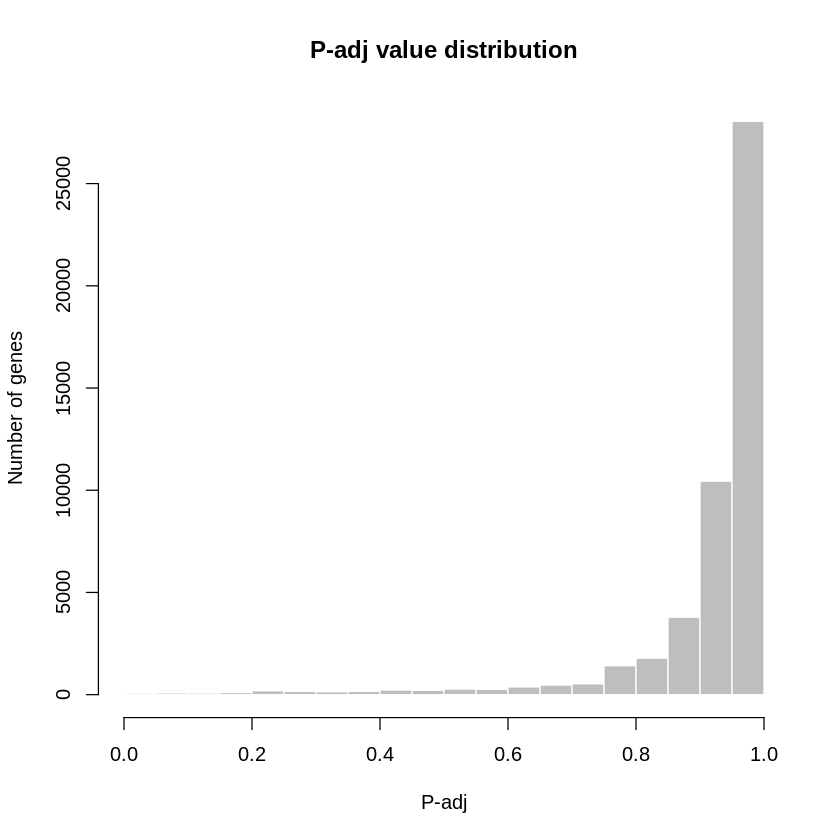

In [33]:
# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

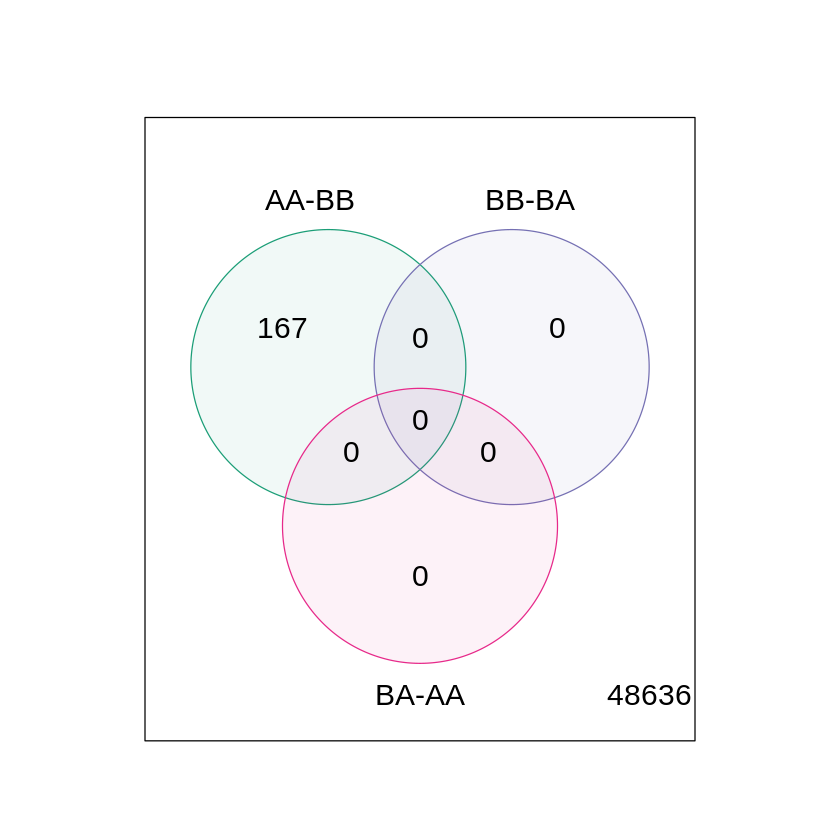

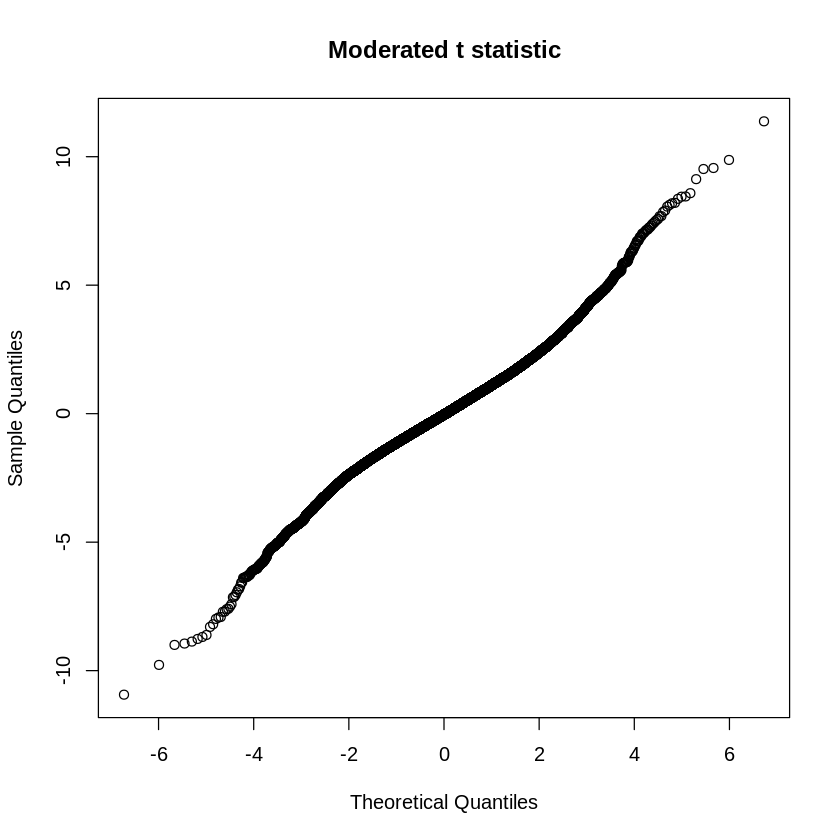

In [34]:
# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05, lfc=0)

# Venn diagram of results
vennDiagram(dT, circle.col=palette())

# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

[1] "AA-BB" "BB-BA" "BA-AA"

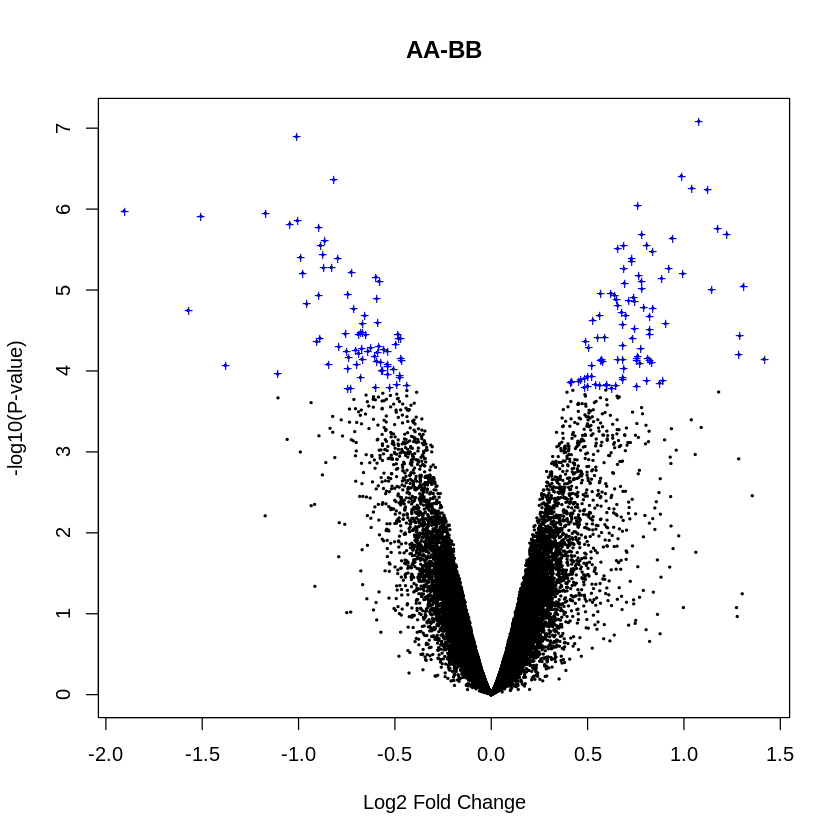

In [35]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
# Please note that the code provided to generate graphs serves as a guidance to
# the users. It does not replicate the exact GEO2R web display due to multitude
# of graphical options.
#
# The following will produce basic volcano plot using limma function:
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

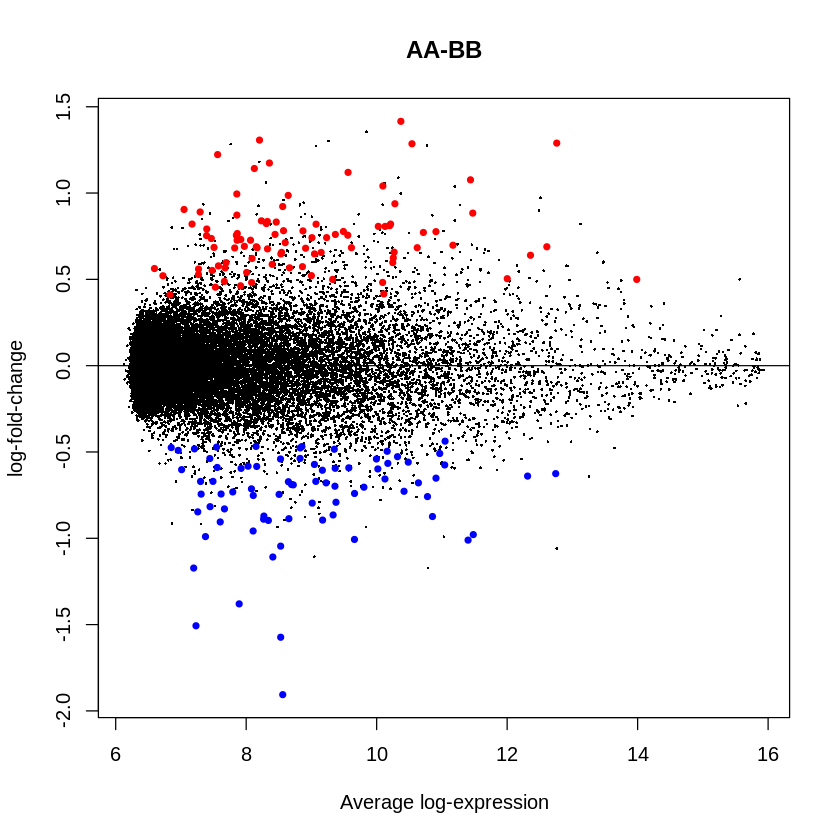

In [36]:
# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

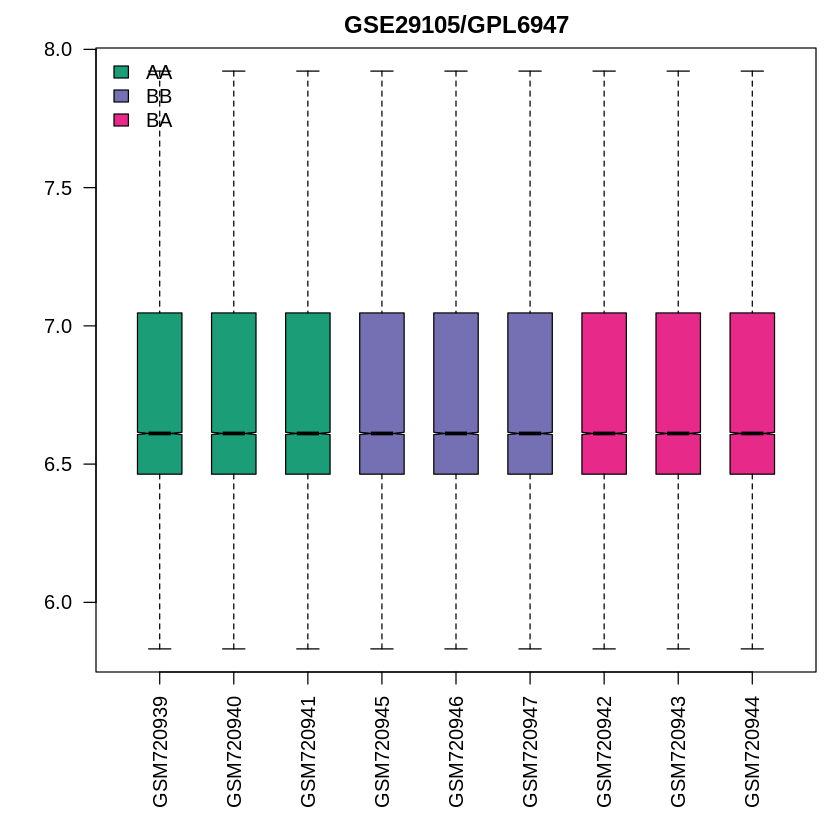

In [37]:
################################################################
# General expression data analysis
ex <- exprs(gset)

# box-and-whisker plot
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE29105", "/", annotation(gset), sep ="")
boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")

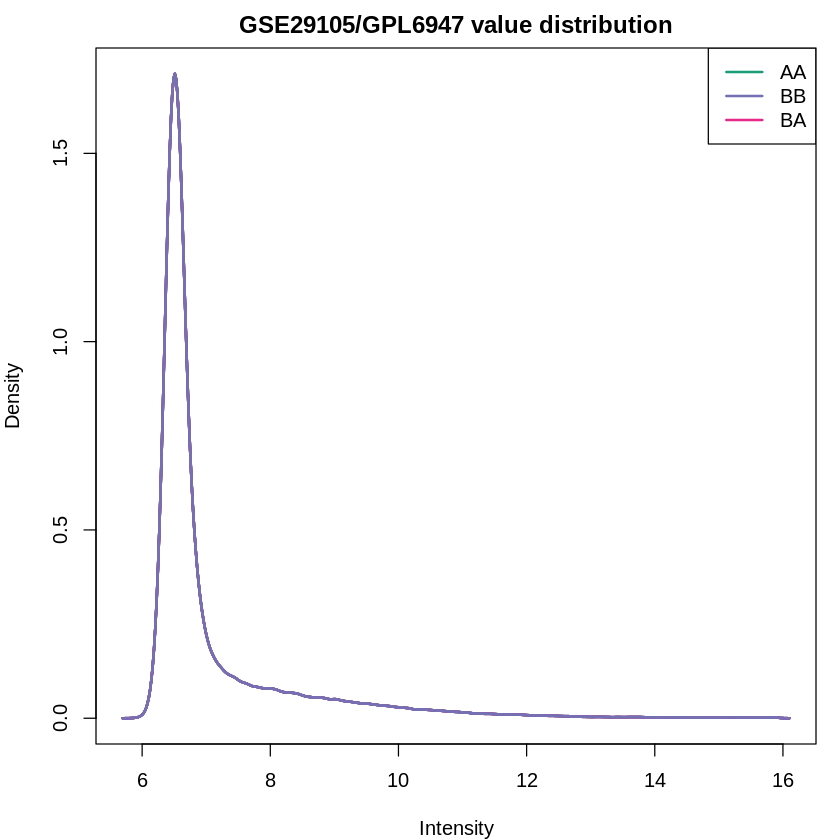

In [38]:
# expression value distribution
par(mar=c(4,4,2,1))
title <- paste ("GSE29105", "/", annotation(gset), " value distribution", sep ="")
plotDensities(ex, group=gs, main=title, legend ="topright")

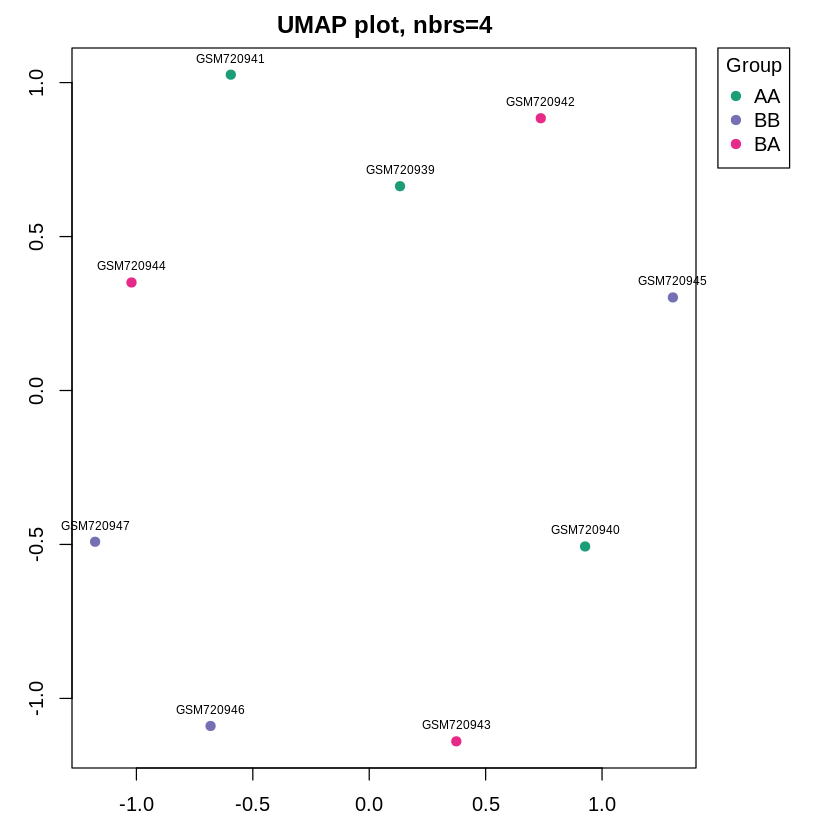

In [43]:
# UMAP plot (dimensionality reduction)
ex <- na.omit(ex) # eliminate rows with NAs
ex <- ex[!duplicated(ex), ]  # remove duplicates
ump <- umap(t(ex), n_neighbors = 4, random_state = 123)
par(mar=c(3,3,2,6), xpd=TRUE)
plot(ump$layout, main="UMAP plot, nbrs=4", xlab="", ylab="", col=gs, pch=20, cex=1.5)
legend("topright", inset=c(-0.15,0), legend=levels(gs), pch=20,
col=1:nlevels(gs), title="Group", pt.cex=1.5)

# library("maptools")  # point labels without overlaps
# pointLabel(ump$layout, labels = rownames(ump$layout), method="SANN", cex=0.6)
text(ump$layout, labels = rownames(ump$layout), cex = 0.6, pos = 3)

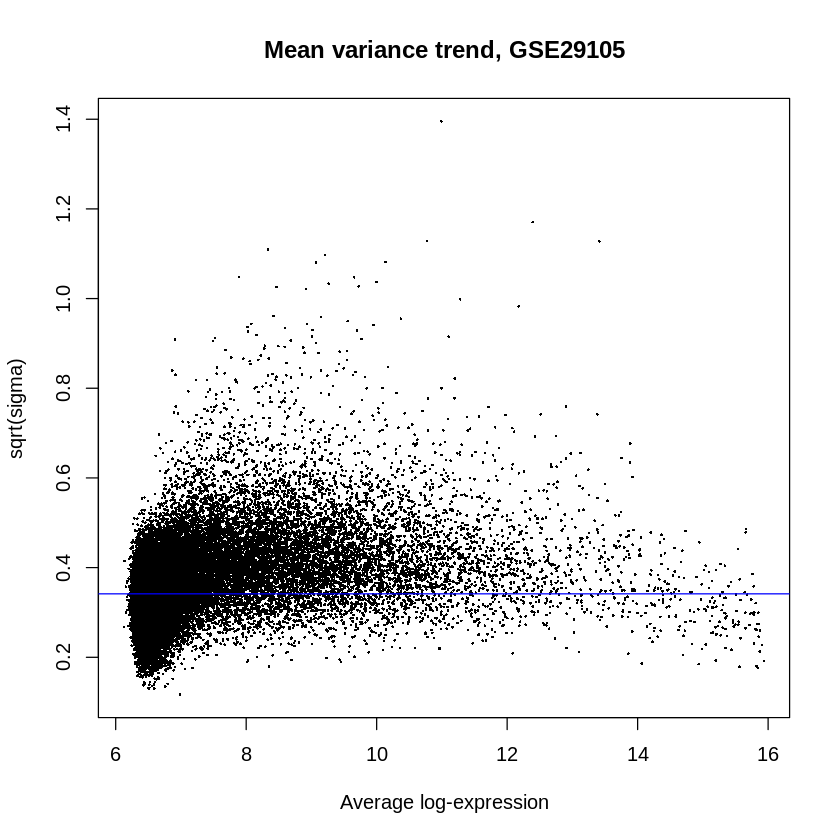

In [42]:
# mean-variance trend, helps to see if precision weights are needed
plotSA(fit2, main="Mean variance trend, GSE29105")